In [ ]:
%pip install svetlanna
%pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas

In [31]:
import torch
from svetlanna import elements
from svetlanna import SimulationParameters
from svetlanna import Parameter
import matplotlib.pyplot as plt
from svetlanna import wavefront as w
from svetlanna.units import ureg

# Use of SLM

Spatial Light Modulator(SLM) allows to control the phase distribution of the incident wavefront. For the aim to define the SLM element, it's necessary to pass the size of the modulator's aperture $height~\times~width$, mask with the required resolution. 

In this example we will create numerical twin of the modulator [PLUTO-2.1 LCOS Spatial Light Modulator](https://holoeye.com/products/spatial-light-modulators/pluto-2-1-lcos-phase-only-refl/).

## Creating numerical mesh with using `SimulationParameters` class

In [54]:
wavelength = 1064 * ureg.nm # wavelength, mm
lx = 60 * ureg.mm # screen size along x-axis, mm
ly = 60 * ureg.mm # screen size along y-axis, mm

Nx = 1200 # number of nodes along x-axis
Ny = 1100 # number of nodes along y-axis

x_length = torch.linspace(-lx / 2, lx / 2, Nx)
y_length = torch.linspace(-ly / 2, ly / 2, Ny)

# define simulation parameters
params = SimulationParameters(
    axes={
            'W': x_length,
            'H': y_length,
            'wavelength': wavelength
        }
)

In [55]:
# return 2d-tensors of x and y coordinates
x_grid, y_grid = params.meshgrid(x_axis='W', y_axis='H')

## Creating a Gaussian beam using `svetlanna.wavefront.gaussian_beam`

Let's create a Gaussian beam that will fall on the nonlinear element:

In [56]:
incident_wavefront = w.Wavefront.gaussian_beam(
    simulation_parameters=params,
    waist_radius=1 * ureg.mm,
    distance=2 * ureg.mm
)

phase_before_slm = incident_wavefront.phase

## Creating nonlinear element using `svetlanna.elements.SpatialLightModulator`

In this section we will create a slm with determined mask. Mask's resolution and size of the numerical mesh may not match

In [57]:
slm_height = 8 * ureg.mm
slm_width = 15 * ureg.mm

mask = 2 * torch.pi * torch.rand(1080, 1920)

In [58]:
slm = elements.SpatialLightModulator(
    simulation_parameters=params,
    mask=mask,
    height=slm_height,
    width=slm_width
)

slm_aperture = slm.get_aperture

slm_transmission_function = slm.transmission_function

c:\Users\gunne\projects\python\dnn\SVETlANNa.docs\.venv\Lib\site-packages\svetlanna\elements\slm.py:127: UserWarning: New mask size torch.Size([146, 300]) is smaller than the original one torch.Size([1080, 1920])! 
  warnings.warn(f"New mask size {resized_mask.size()} is smaller than the original one {self.mask.size()}! ")


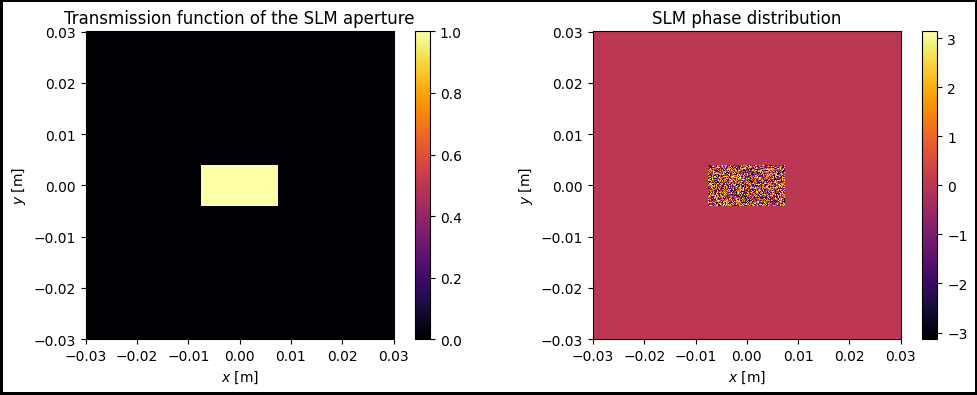

In [59]:
fig, ax = plt.subplots(
    1, 2, figsize=(12, 4), edgecolor='black', linewidth=3, frameon=True
)

im1 = ax[0].pcolormesh(x_grid, y_grid, slm_aperture, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title(r'Transmission function of the SLM aperture')
ax[0].set_xlabel('$x$ [m]')
ax[0].set_ylabel('$y$ [m]')
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].pcolormesh(x_grid, y_grid, torch.real(torch.log(slm_transmission_function)/1j), cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title('SLM phase distribution')
ax[1].set_xlabel('$x$ [m]')
ax[1].set_ylabel('$y$ [m]')
fig.colorbar(im2, ax=ax[1])

plt.show()

In [60]:
field_after_slm = slm.forward(incident_wavefront=incident_wavefront)

phase_after_slm = field_after_slm.phase

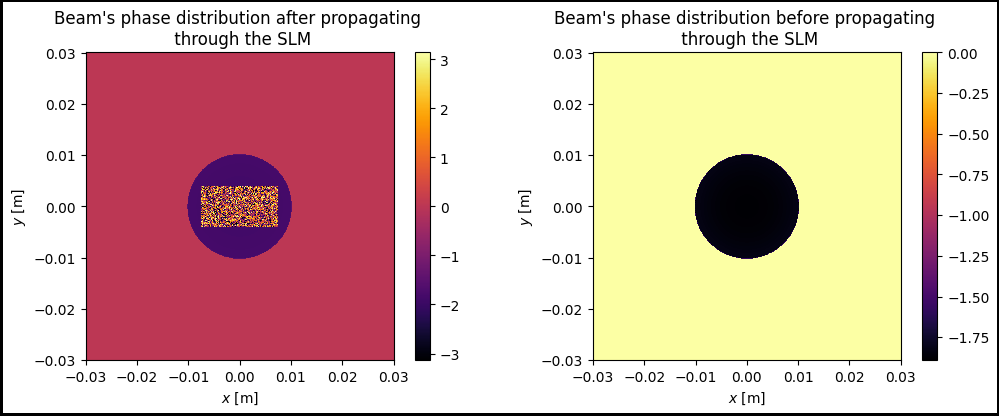

In [61]:
fig, ax = plt.subplots(
    1, 2, figsize=(12, 4), edgecolor='black', linewidth=3, frameon=True
)

im1 = ax[0].pcolormesh(x_grid, y_grid, phase_after_slm, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title("Beam's phase distribution after propagating \n through the SLM")
ax[0].set_xlabel('$x$ [m]')
ax[0].set_ylabel('$y$ [m]')
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].pcolormesh(x_grid, y_grid, phase_before_slm, cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title("Beam's phase distribution before propagating \n through the SLM")
ax[1].set_xlabel('$x$ [m]')
ax[1].set_ylabel('$y$ [m]')
fig.colorbar(im2, ax=ax[1])

plt.show()